In [89]:
import torch
import torch.nn.functional as F
import json, copy, os
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

In [90]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.cluster import KMeans
import scipy as sp
from scipy.cluster import hierarchy
from functools import reduce

In [91]:
from tqdm import tqdm

In [92]:
project_dir = "/home/miskai/デスクトップ/related-work/scene-graph-benchmark"
image_file = json.load(open(f'{project_dir}/datasets/vg/image_data.json'))
vocab_file = json.load(open(f'{project_dir}/datasets/vg/VG-SGG-dicts-with-attri.json'))
data_file = h5py.File(f'{project_dir}/datasets/vg/VG-SGG-with-attri.h5', 'r')
# remove invalid image
corrupted_ims = [1592, 1722, 4616, 4617]
tmp = []
for item in image_file:
    if int(item['image_id']) not in corrupted_ims:
        tmp.append(item)
image_file = tmp

In [98]:
result_path = '../checkpoints/motifs-knowledgetrans-predcls-exmp-2cluster/avg_kt_cls1'
detected_origin_path = f'{result_path}/inference/VG_stanford_filtered_with_attribute_test/'
detected_origin_result = torch.load(detected_origin_path + 'eval_results.pytorch')
detected_info = json.load(open(detected_origin_path + 'visual_info.json'))

In [99]:
pred2idx = vocab_file["predicate_to_idx"]
idx2pred = vocab_file["idx_to_predicate"]

In [100]:
def bbox_match(pred, gt):
    """Args:
        pred: [x0, y0, x1, y1]
        gt: same as above
    Returns: whether objects in gt and prediction are seen as same objects
    """
    xA = max(pred[0], gt[0])
    yA = max(pred[1], gt[1])
    xB = min(pred[2], gt[2])
    yB = min(pred[3], gt[3])
    intra_area = max(0, xB-xA+1)*max(0, yB-yA+1)
    pred_area = (pred[2]-pred[0]+1)*(pred[3]-pred[1]+1)
    gt_area = (gt[2]-gt[0]+1)*(gt[3]-gt[1]+1)
    iou = intra_area/float(pred_area+gt_area-intra_area)
    return iou>0.5

In [101]:
def find_match(pred_rels, gt_rels):
    """
    pred_rels, gt_rels: relation triplets
        sub_label: label of subject (String)
        obj_label: label of object  (String)
        sub_bbox:  bbox of subject  ([num_rel, 4])
        obj_bbox:  bbox of object   ([num_rel, 4])
        rel_label: relation label   (Int)
    """
    selected_pred_label = []
    selected_gt_label = []
    # for each gt, check pair matched prediction (if it has corresponding prediction, put 1)
    pair_found = [0 for x in range(len(gt_rels))]
    # for each prediction, check all matched gt
    pred_to_gt = [[] for x in range(len(pred_rels))]
    for i, pre in enumerate(pred_rels):
        for j, gt in enumerate(gt_rels):
            if pre["sub_label"]==gt["sub_label"] and pre["obj_label"]==gt["obj_label"] and bbox_match(pre["sub_bbox"],gt["sub_bbox"] ) and bbox_match(pre["obj_bbox"], gt["obj_bbox"]):
                selected_pred_label.append(pre["rel_label"])
                selected_gt_label.append(gt["rel_label"])
                pair_found[j] = 1
                if pre["rel_label"]==gt["rel_label"]:
                    pred_to_gt[i].append(j)
    # print(pred_to_gt)
    return pred_to_gt, selected_pred_label, selected_gt_label, pair_found

In [104]:
pred = []
gt = []
gt_nums = []
recalls = []
pair_matchs = []
idxs = []
# for i in tqdm(range(1)):
for i in tqdm(range(26446)):
    gt_num = 0
    prediction = detected_origin_result["predictions"][i]
    groundtruths = detected_origin_result["groundtruths"][i]
    idx2label = vocab_file['idx_to_label']
    idx2pred = vocab_file['idx_to_predicate']
    # prediction boxes
    pred_boxes = prediction.bbox
    # predicted object label corresponding to bbox above
    pred_labels = prediction.get_field("pred_labels").long().tolist()
    # ground truth boxes
    gt_boxes = groundtruths.bbox
    # ground truth label corresponding to bbox above
    gt_labels = groundtruths.get_field("labels").tolist()
    # rel pair lists
    pred_rels = []
    gt_rels =[]
    # ground truth triplet
    gt_triplets = groundtruths.get_field('relation_tuple').tolist()
    gt_num = len(gt_triplets)
    gt_nums.append(gt_num)
    for tri in gt_triplets:
        tmp = {}
        tmp["sub_label"] = idx2label[str(gt_labels[tri[0]])]
        tmp["obj_label"] = idx2label[str(gt_labels[tri[1]])]
        tmp["sub_bbox"] = gt_boxes[tri[0]].tolist()
        tmp["obj_bbox"] = gt_boxes[tri[1]].tolist()
        tmp["rel_label"] = tri[2]
        gt_rels.append(tmp)
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').long().tolist()
    pred_rel_label = prediction.get_field('pred_rel_labels').long()[:100].tolist()
    for j, k in zip(pred_rel_pair, pred_rel_label):
        tmp = {}
        tmp["sub_label"] = idx2label[str(pred_labels[j[0]])]
        tmp["obj_label"] = idx2label[str(pred_labels[j[1]])]
        tmp["sub_bbox"] = pred_boxes[j[0]].tolist()
        tmp["obj_bbox"] = pred_boxes[j[1]].tolist()
        tmp["rel_label"] = k
        pred_rels.append(tmp)
    pred_to_gt, selected_pred_label, selected_gt_label, pair_found = find_match(pred_rels, gt_rels)
    match = reduce(np.union1d, pred_to_gt)
    rec = float(len(match))/float(gt_num)
    recalls.append(rec)
    pair_matchs.append(float(np.sum(pair_found))/float(gt_num))
    pred = pred+selected_pred_label
    gt = gt+selected_gt_label
    # idxs = idxs+[i for _ in range(len(selected_gt_label))]

100%|██████████| 26446/26446 [00:51<00:00, 514.94it/s]


In [105]:
len(pred) == len(gt)

True

In [106]:
# Recall@100
np.mean(recalls)

0.48788207275987816

In [107]:
# pair match accuracy
np.mean(pair_matchs)

0.9821621861690155

## Confusion Matrix

In [112]:
val_mat = confusion_matrix(gt, pred)

In [113]:
mat = copy.deepcopy(val_mat).astype(float)
for i in range(mat.shape[0]):
    if np.sum(mat[i]):
        mat[i] = mat[i]/np.sum(mat[i])

In [114]:
labels = np.array([idx2pred[str(i)] for i in set(gt)], dtype=str)

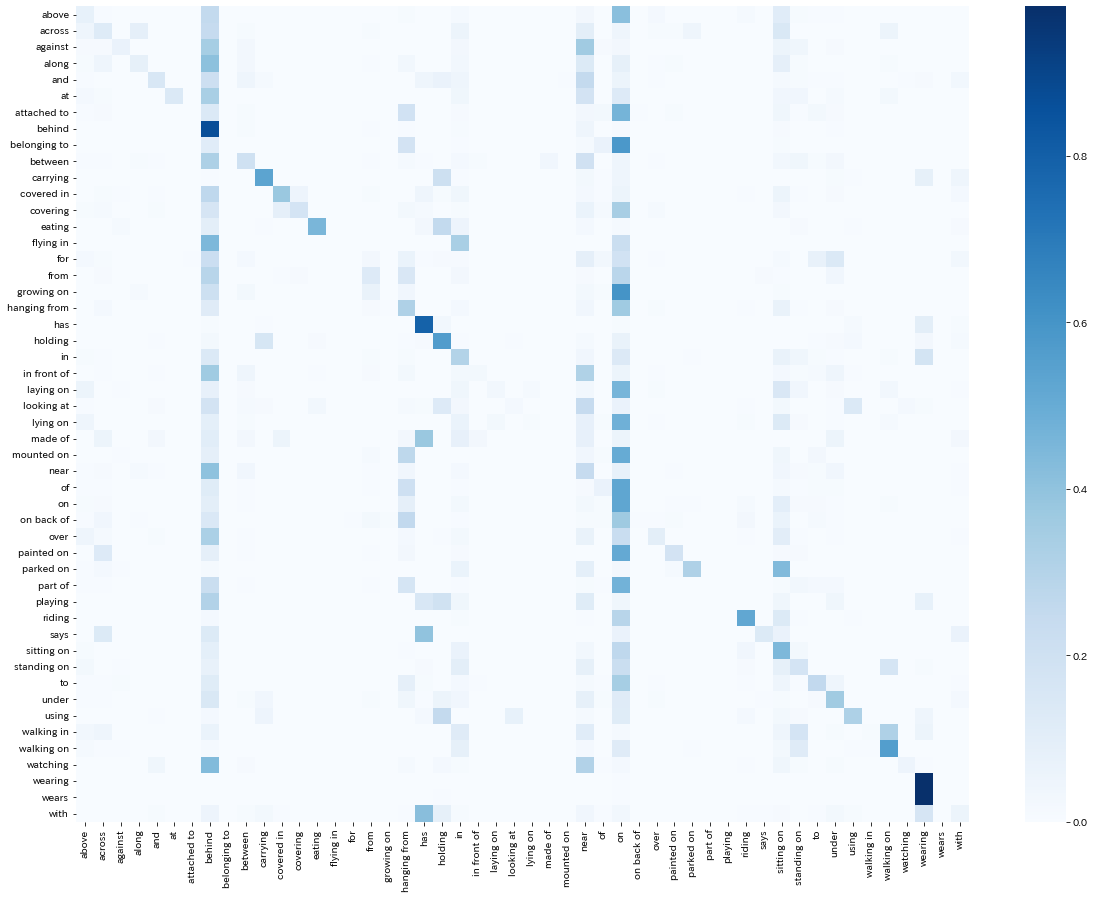

In [116]:
plt.figure(figsize=(20,15))
sns.heatmap(mat, cmap="Blues", xticklabels=labels, yticklabels=labels)
save_path = os.path.join(result_path, "conf_matrix.png")
plt.savefig(save_path, dpi=300)

# Hierarchical Analysis

In [117]:
top10 = ["on", "has", "wearing", "of", "in", "near", "behind", "with", "holding", "above"]
middle = ["under", "wears", "sitting on", "in front of", "riding", "standing on", "at", "attached to", "over", "carrying", "walking on", "for", "looking at", "watching", "hanging from", "belonging to", "and", "parked on", "between", "laying on", "along", "eating", "covering", "covered in", "part of"]
bottom15 = ["using", "to", "on back of", "across", "mounted on", "lying on", "walking in", "against", "from", "growing on", "painted on", "made of", "playing", "says", "flying in"]
top10 = [pred2idx[t] for t in top10]
middle = [pred2idx[m] for m in middle]
bottom15 = [pred2idx[b] for b in bottom15]

In [121]:
json_file = "../datasets/vg/causal/predcls_clusters/motifs/rel_base_2cluster.json"
taxonomy = open(json_file)
taxonomy = json.load(taxonomy)

In [122]:
pars = taxonomy["children"]["root"]
par_dic = {}
for par in pars:
    for ch in taxonomy["children"][par]:
        par_dic[pred2idx[ch]] = par

In [123]:
count = 0
correct = 0
top_count = 0
top_correct = 0
mid_count = 0
mid_correct = 0
bot_count = 0
bot_correct = 0
failed_predicate = []
for pre, gr in zip(pred, gt):
    if par_dic[pre]==par_dic[gr]:
        correct += 1
        if gr in top10:
            top_correct += 1
        elif gr in middle:
            mid_correct += 1
        else:
            bot_correct += 1
    else:
        failed_predicate.append((idx2pred[str(pre)], idx2pred[str(gr)])) 
    count += 1
    if gr in top10:
        top_count += 1
    elif gr in middle:
        mid_count += 1
    else:
        bot_count += 1
print(f"count: {count}")
print(f"top10 count: {top_count}")
print(f"middle count: {mid_count}")
print(f"bottom15 count: {bot_count}")
print(f"Root Accuracy: {correct/count}")
print(f"Top10 Accuracy: {top_correct/top_count}")
print(f"Middle Accuracy: {mid_correct/mid_count}")
print(f"Bottom15 Accuracy: {bot_correct/bot_count}")

count: 234847
top10 count: 209229
middle count: 23646
bottom15 count: 1972
Root Accuracy: 0.9430650593790851
Top10 Accuracy: 0.9461499122970525
Middle Accuracy: 0.9160534551298317
Bottom15 Accuracy: 0.9396551724137931
